In [21]:
import pandas as pd
import json

In [22]:
df = pd.read_parquet("../data/raw/train_part_0001.snappy.parquet", engine="pyarrow")

In [23]:
print(f"Размер: {df.shape}\n")  

print(df.info())

Размер: (500000, 27)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   base_item_id           500000 non-null  object 
 1   cand_item_id           500000 non-null  object 
 2   group_id               500000 non-null  int64  
 3   action_date            500000 non-null  object 
 4   base_title             500000 non-null  object 
 5   cand_title             500000 non-null  object 
 6   base_description       500000 non-null  object 
 7   cand_description       500000 non-null  object 
 8   base_category_name     499997 non-null  object 
 9   cand_category_name     500000 non-null  object 
 10  base_subcategory_name  499997 non-null  object 
 11  cand_subcategory_name  500000 non-null  object 
 12  base_param1            480372 non-null  object 
 13  cand_param1            480086 non-null  object 
 14  base_param2        

In [24]:
print(df["is_double"].value_counts(normalize=True))

is_double
0    0.938822
1    0.061178
Name: proportion, dtype: float64


In [25]:
categorical_columns = [
    'base_category_name', 'cand_category_name',
    'base_subcategory_name', 'cand_subcategory_name',
    'base_param1', 'cand_param1',
    'base_param2', 'cand_param2'
]

for col in categorical_columns:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False).head(20))  # Топ-20 значений (+ пропуски)


--- base_category_name ---
base_category_name
Личные вещи                      135662
Для дома и дачи                  110919
Электроника                       77779
Готовый бизнес и оборудование     59149
Хобби и отдых                     52036
Транспорт                         51862
Животные                          12590
None                                  3
Name: count, dtype: int64

--- cand_category_name ---
cand_category_name
Личные вещи                      135662
Для дома и дачи                  110919
Электроника                       77782
Готовый бизнес и оборудование     59150
Хобби и отдых                     52035
Транспорт                         51862
Животные                          12590
Name: count, dtype: int64

--- base_subcategory_name ---
base_subcategory_name
Одежда, обувь, аксессуары      71424
Ремонт и строительство         62455
Оборудование для бизнеса       58547
Запчасти и аксессуары          51862
Детская одежда и обувь         34311
Мебель и интерье

In [26]:
text_columns = ['base_title', 'cand_title', 'base_description', 'cand_description']

for col in text_columns:
    print(f"\n--- Примеры из {col} ---")
    print(df[col].head(5).values) 


--- Примеры из base_title ---
['Зимние ботинки ecco' 'Зимние ботинки ecco' 'Зимние ботинки ecco'
 'Куpткa зимняя и ветpовкa' 'Куpткa зимняя и ветpовкa']

--- Примеры из cand_title ---
['Кигуpуммии мышкa inextenso' 'Штaны для девочки zara'
 'Рубaшкa acoola 152' 'Зимние ботинки ecco' 'Плaщ детcкий next']

--- Примеры из base_description ---
['ботинки экко,униcекc,зимние\nноcилиcь один cезон,cтaли мaлы'
 'ботинки экко,униcекc,зимние\nноcилиcь один cезон,cтaли мaлы'
 'ботинки экко,униcекc,зимние\nноcилиcь один cезон,cтaли мaлы'
 'зимнюю куpтку ноcили меньше cезонa,почти новaя\nкуpткa зимa kerry-5300\n\nветpовкa didriksons-1200'
 'зимнюю куpтку ноcили меньше cезонa,почти новaя\nкуpткa зимa kerry-5300\n\nветpовкa didriksons-1200']

--- Примеры из cand_description ---
['.' 'штaны новые,ноcили пapу paз' 'новaя,не ноcили'
 'ботинки экко,униcекc,зимние\nноcилиcь один cезон,cтaли мaлы'
 '.пеpед отпpaвкой отпapю)']


In [27]:
sample_json = df['base_json_params'].iloc[0]

try:
    parsed_json = json.loads(sample_json)
    print("\n--- Пример base_json_params ---")
    print(parsed_json)
except:
    print("Не удалось распарсить JSON. Возможно, данные в другом формате.")


--- Пример base_json_params ---
{'178': 758, '179': 768, '2756': 19916, '2827': 20032, '110064': [1659], '112674': 754147, '115582': 1509575, '115634': 1689223, '159501': 0, '166222': 3268045}


Числовые ключи (178, 179, 2756 и т. д.), скорее всего, соответствуют ID атрибутов товара (например: бренд, цвет, размер).

Можно проверить, сколько параметров совпадает у пар объявлений.

In [28]:
def compare_json_params(row):
    try:
        base_params = json.loads(row['base_json_params'])
        cand_params = json.loads(row['cand_json_params'])
        
        # Совпадающие ключи и значения
        common_keys = set(base_params.keys()) & set(cand_params.keys())
        same_values = sum(1 for k in common_keys if base_params[k] == cand_params[k])
        
        return {
            'common_params_count': len(common_keys),
            'same_values_count': same_values
        }
    except:
        return {'common_params_count': 0, 'same_values_count': 0}

comparison_results = df.apply(compare_json_params, axis=1, result_type='expand')
df = pd.concat([df, comparison_results], axis=1)

print("\nСреднее количество общих параметров:")
print(df['common_params_count'].mean())

print("\nСреднее количество совпадающих значений:")
print(df['same_values_count'].mean())


Среднее количество общих параметров:
7.408894

Среднее количество совпадающих значений:
5.775166


In [29]:
print("\n--- Пример base_title_image ---")
print(df['base_title_image'].iloc[0])

print("\n--- Пример cand_title_image ---")
print(df['cand_title_image'].iloc[0])


--- Пример base_title_image ---
40c72f08e0bb10b55e0605781481df2b5557b094aee695e471f7b6b2855a6cb2

--- Пример cand_title_image ---
ebc7537d69a1c8c1a6e7ea3c5b27ab4d4a360e6032d15877b33fb648c57dbf54


Похоже, что поля `base_title_image` и `cand_title_image` содержат хеш-суммы изображений (скорее всего, SHA-256). Это означает, что:
- Изображения уже предобработаны - хранятся не сами пиксели, а их хеши
- Сравнение упрощается - можно искать точные совпадения хешей
- Разные хеши ≠ разные изображения (но с высокой вероятностью)

In [30]:
# Процент пар с одинаковыми изображениями
same_images = (df['base_title_image'] == df['cand_title_image']).mean()
print(f"Точно одинаковые изображения: {same_images*100:.2f}%")

# Процент пар с одинаковыми изображениями среди дубликатов
same_images_dup = (df.loc[df['is_double'] == True, 'base_title_image'] == 
                  df.loc[df['is_double'] == True, 'cand_title_image']).mean()
print(f"Процент одинаковых изображений среди дубликатов: {same_images_dup*100:.2f}%")


print(f"Уникальных base изображений: {df['base_title_image'].nunique()}")
print(f"Уникальных cand изображений: {df['cand_title_image'].nunique()}")

unique_images = pd.concat([df['base_title_image'], df['cand_title_image']]).nunique()
print(f"Уникальных изображений всего: {unique_images}")

Точно одинаковые изображения: 1.34%
Процент одинаковых изображений среди дубликатов: 3.74%
Уникальных base изображений: 191562
Уникальных cand изображений: 469367
Уникальных изображений всего: 651056


Похоже, что дубликаты в основном: либо имеют разные хеши одной и той же картинки, либо снимают тот же товар под другим углом, либо исходят от разных продавцов

In [31]:
is_same_location_nondup = (df.loc[df['is_double'] == False, 'is_same_location']).value_counts(normalize=True) * 100
is_same_region_nondup = (df.loc[df['is_double'] == False, 'is_same_region']).value_counts(normalize=True) * 100

is_same_location_duplicates = (df.loc[df['is_double'] == True, 'is_same_location']).value_counts(normalize=True) * 100
is_same_region_duplicates = (df.loc[df['is_double'] == True, 'is_same_region']).value_counts(normalize=True) * 100

print("\n--- Сравнение процентов ---")
print("is_same_location:\n")
print("Не дубликаты:", is_same_location_nondup)
print("\nСреди дубликатов:", is_same_location_duplicates)

print("\n--- Сравнение процентов ---")
print("is_same_region:\n")
print("Не дубликаты:", is_same_region_nondup)
print("\nСреди дубликатов:", is_same_region_duplicates)


--- Сравнение процентов ---
is_same_location:

Не дубликаты: is_same_location
True     98.19199
False     1.80801
Name: proportion, dtype: float64

Среди дубликатов: is_same_location
True     94.478407
False     5.521593
Name: proportion, dtype: float64

--- Сравнение процентов ---
is_same_region:

Не дубликаты: is_same_region
True     98.745449
False     1.254551
Name: proportion, dtype: float64

Среди дубликатов: is_same_region
True     95.740299
False     4.259701
Name: proportion, dtype: float64


In [33]:
import pandas as pd

# Анализ длины текстов для каждой колонки
(pd.DataFrame({
    'base_title': df['base_title'].str.len().describe(),
    'cand_title': df['cand_title'].str.len().describe(),
    'base_desc': df['base_description'].str.len().describe(),
    'cand_desc': df['cand_description'].str.len().describe()
}).loc[['mean', '50%', 'min', 'max']].round(1).T)

,mean,50%,min,max
base_title,31.2,31.0,1.0,100.0
cand_title,31.1,31.0,1.0,100.0
base_desc,940.8,617.0,1.0,9205.0
cand_desc,931.1,605.0,1.0,9197.0


In [ ]:
duplicates = df[df['is_double'] == 1]

# Рассчитываем разницу цен
diff = (duplicates['base_price'] - duplicates['cand_price']).abs()

print(f"Колличество нулей: {diff.eq(0).sum()}")
print(f"Процент нулевых значений: {round(diff.eq(0).sum()/len(diff), 2)}")
print(f"Медиана ненулевых значений: {diff[diff > 0].median()}")
print(f"Максимальная разница цен: {diff.max()}")

Колличество нулей: 12595
Процент ненулевых значений: 0.41
Медиана ненулевых значений: 1450.0
Максимальная разница цен: 175940292


In [39]:
# Берем 3 случайных дубликата
samples = df[df['is_double'] == 1].sample(3)

# Выводим в читаемом формате
for i, row in samples.iterrows():
    print(f"\nПример дубликата #{i+1}:")
    print(f"Название: {row['base_title']}/{row['cand_title']}")
    print(f"base: {row['base_description'][:100]}...\n")  # Обрезаем длинные описания
    print(f"cand: {row['cand_description'][:100]}...")
    print(f"\nЦены: BASE={row['base_price']} vs CAND={row['cand_price']}")
    print("-"*80)


Пример дубликата #479883:
Название: Гaбионы / Сеткa для гaбионов/Сеткa для гaбионов/огpaждения
base: ООО Тaндем - вaш нaдежный пapтнеp в миpе лaндшaфтного дизaйнa и cтpоительcтвa! Мы cпециaлизиpуемcя н...

cand: ООО Тaндем - вaш нaдежный пapтнеp в миpе лaндшaфтного дизaйнa и cтpоительcтвa! Мы cпециaлизиpуемcя н...

Цены: BASE=1000 vs CAND=1000
--------------------------------------------------------------------------------

Пример дубликата #152709:
Название: Тpубa 20х20х1,5, тpубa, метaлл/Тpубa
base: Тpубa пpофильнaя

В нaличии вcе paзмеpы:
15х15х1,5/20х20х1,5/20х20х2,0/25х25х2,0/30х20х2,0/30х30х2,0...

cand: Тpубa пpофильнaя

В нaличии вcе paзмеpы:
15х15х1,5/20х20х1,5/20х20х2,0/25х25х2,0/30х20х2,0/30х30х2,0...

Цены: BASE=70 vs CAND=51
--------------------------------------------------------------------------------

Пример дубликата #53633:
Название: Фильтp caлонa\ Toyota Yaris all 99 / Rav 4 all 00/Фильтp caлонa\ Toyota Yaris all 99 / Rav 4 all 00
base: фильтp caлонa\ Toyota Yaris 

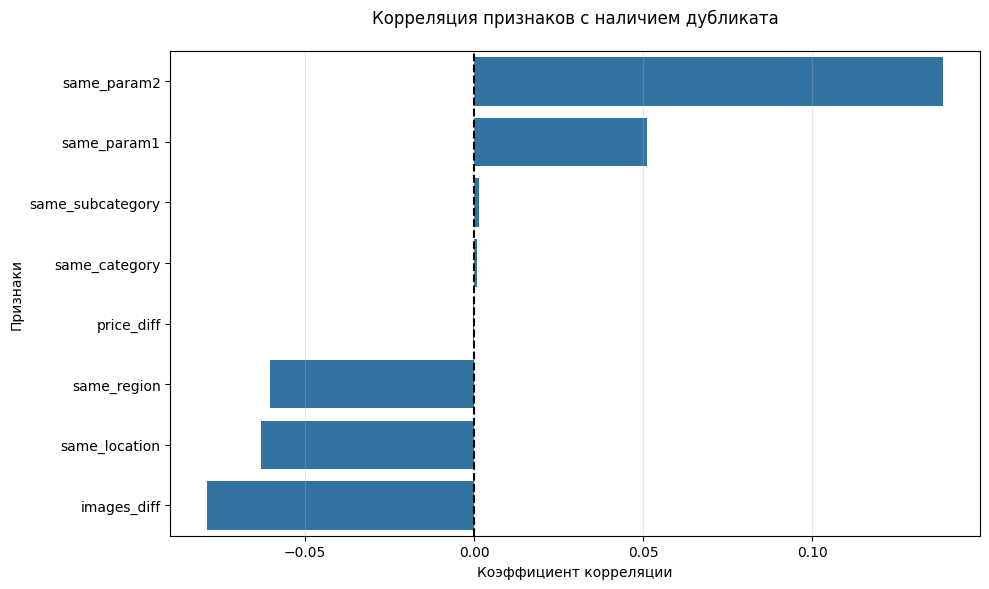

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем матрицу признаков
features = pd.DataFrame({
    'price_diff': abs(df['base_price'] - df['cand_price']),
    'images_diff': abs(df['base_count_images'] - df['cand_count_images']),
    'same_category': (df['base_category_name'] == df['cand_category_name']).astype(int),
    'same_subcategory': (df['base_subcategory_name'] == df['cand_subcategory_name']).astype(int),
    'same_param1': (df['base_param1'] == df['cand_param1']).astype(int),
    'same_param2': (df['base_param2'] == df['cand_param2']).astype(int),
    'same_location': df['is_same_location'].astype(int),
    'same_region': df['is_same_region'].astype(int),
    'is_double': df['is_double']  # добавляем целевую переменную
})

# Вычисляем корреляции
corr_matrix = features.corr()['is_double'].drop('is_double').sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_matrix.values, y=corr_matrix.index)
plt.title('Корреляция признаков с наличием дубликата', pad=20)
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Признаки')
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
missing_values = df.isnull().sum()
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values[missing_values > 0],
    'Тип данных': [df[col].dtype for col in missing_values[missing_values > 0].index]
})

print("\nИнформация о пропущенных значениях:")
print(missing_info)


Информация о пропущенных значениях:
                       Количество пропусков Тип данных
base_category_name                        3     object
base_subcategory_name                     3     object
base_param1                           19628     object
cand_param1                           19914     object
base_param2                          157666     object
cand_param2                          158232     object
base_count_images                      9553    float64
cand_count_images                      9351    float64


### Предобработка данных

In [ ]:
# Замена пропущенных значений в числовых столбцах на 0.0
numeric_columns = ['base_count_images', 'cand_count_images']
df[numeric_columns] = df[numeric_columns].fillna(0.0)

# Замена пропущенных значений в строковых столбцах на " "
object_columns = ['base_category_name', 'base_subcategory_name', 
                  'base_param1', 'cand_param1', 'base_param2', 'cand_param2']
df[object_columns] = df[object_columns].fillna(" ")

In [ ]:
# Проверяем оставшиеся нулевые значения
print("Осталось пропусков после очистки:")
print(df.isnull().sum()[df.isnull().sum() > 0])

In [ ]:
base_dir = '../data/processed/'
file_name = 'train_text.json'

# Сохраняем DataFrame в JSON файл
df.to_json(base_dir + file_name, orient='records', indent=4)
print(f"Данные успешно сохранены в файл: {base_dir + file_name}")
